This notebook implements a Convolutional Neural Network (CNN) for image classification. The primary goal is to classify images of shoes into three distinct brands: Adidas, Converse, and Nike.

The dataset used in this project is sourced from Kaggle and contains images of Adidas, Converse, and Nike shoes. It's ideal for multiclass image classification.

Dataset Link: https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged?select=test

The dataset comprises two folders, test and train, with 114 and 711 images respectively, split at a 0.14 ratio. All images are 240x240 pixels in RGB color format and belong to one of three classes: Adidas, Converse, or Nike.

In [693]:
# Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

Data Loading, Preprocessing, and Augmentation

In [694]:
from zipfile import ZipFile
dataset ='/content/archive.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('done')

done


In [695]:
#printing first 5 directories of adidas, converse and nike shoes
adidas_people = os.listdir('/content/train/adidas')
print(adidas_people[0:5])
converse_people = os.listdir('/content/train/converse')
print(converse_people[0:5])
nike_people = os.listdir('/content/train/nike')
print(nike_people[0:5])

['140.jpg', '78.jpg', '92.jpg', '257.jpg', '69.jpg']
['140.jpg', '78.jpg', '92.jpg', '257.jpg', '69.jpg']
['140.jpg', '78.jpg', '92.jpg', '257.jpg', '69.jpg']


In [696]:
print('Total adidas people: ',len(adidas_people))
print('Total converse people: ',len(converse_people))
print('Total nike people: ',len(nike_people))

Total adidas people:  237
Total converse people:  237
Total nike people:  237


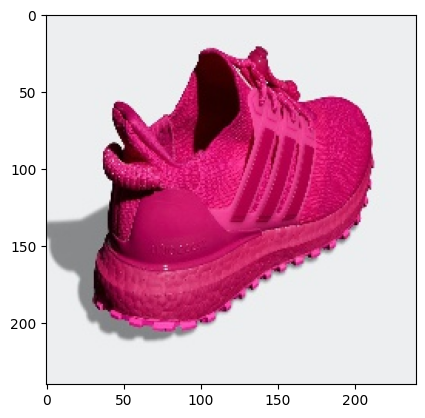

In [697]:
img = mpimg.imread('/content/train/adidas/252.jpg')
imgplot = plt.imshow(img)
plt.show()

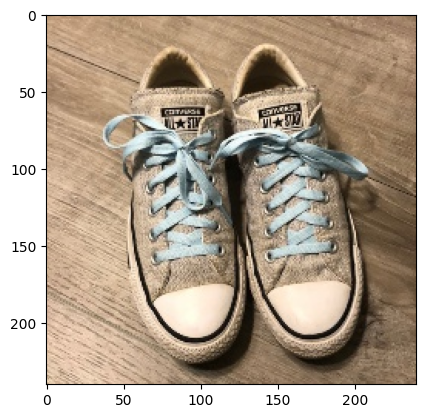

In [698]:
img = mpimg.imread('/content/train/converse/252.jpg')
imgplot = plt.imshow(img)
plt.show()

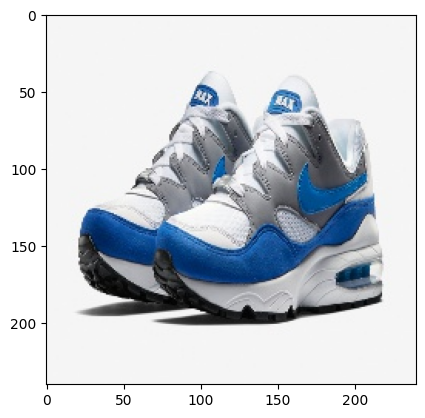

In [699]:
img = mpimg.imread('/content/train/nike/252.jpg')
imgplot = plt.imshow(img)
plt.show()

Creating labels for three classes

adidas --> 0

converse --> 1

nike --> 2

In [700]:
adidas_shoe = [0]*len(adidas_people)
converse_shoe = [1]*len(converse_people)
nike_shoe = [2]*len(nike_people)

In [701]:
print(adidas_shoe[0:5])
print(converse_shoe[0:5])
print(nike_shoe[0:5])

[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]
[2, 2, 2, 2, 2]


In [702]:
train_dir = '/content/train'
test_dir = '/content/test'

In [703]:
# Defining image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [704]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [705]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [706]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 570 images belonging to 3 classes.


In [707]:
# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 141 images belonging to 3 classes.


In [708]:
# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 114 images belonging to 3 classes.


In [709]:
# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Detected number of classes: {class_names}")
print(f"Number of classes: {num_classes}")

Detected number of classes: ['adidas', 'converse', 'nike']
Number of classes: 3


Model Building

In [710]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False


In [711]:
# Freeze the base model layers
base_model.trainable = False

In [712]:
# Create the new model on top of the pre-trained base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [713]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [714]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.3372 - loss: 1.4191
Epoch 1: val_accuracy improved from -inf to 0.42553, saving model to best_cnn_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 733ms/step - accuracy: 0.3370 - loss: 1.4168 - val_accuracy: 0.4255 - val_loss: 1.2293 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4187 - loss: 1.2346
Epoch 2: val_accuracy improved from 0.42553 to 0.46099, saving model to best_cnn_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.4184 - loss: 1.2344 - val_accuracy: 0.4610 - val_loss: 1.1577 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4920 - loss: 1.1507
Epoch 3: val_accuracy improved from 0.46099 to 0.57447, saving model to best_cnn_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 565ms/step - accuracy: 0.4921 - loss: 1.1502 - val_accuracy: 0.5745 - val_loss: 1.1228 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

In [715]:
fine_tune_at = len(base_model.layers) - int(len(base_model.layers) * 0.3)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [716]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Very low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 7,145,475 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [717]:
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 21/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7147 - loss: 0.7839
Epoch 21: val_accuracy did not improve from 0.75887
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 719ms/step - accuracy: 0.7145 - loss: 0.7839 - val_accuracy: 0.6797 - val_loss: 0.7243 - learning_rate: 1.0000e-05
Epoch 22/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8438 - loss: 0.5119
Epoch 22: val_accuracy improved from 0.75887 to 0.79688, saving model to best_cnn_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.8438 - loss: 0.5119 - val_accuracy: 0.7969 - val_loss: 0.6874 - learning_rate: 1.0000e-05
Epoch 23/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7437 - loss: 0.7126
Epoch 23: val_accuracy did not improve from 0.79688
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 570ms/step - accuracy: 0.7441 - loss: 0.7118 - val_accuracy: 0.7422 - val_loss: 0.7048 - learning_rate: 1.0000e-05
Epoch 24/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.8750 - loss: 0.5753
Epoch 24: val_acc

Model Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.8354 - loss: 0.5545
Test Loss: 0.5486
Test Accuracy: 0.8333
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step
Classification Report:
              precision    recall  f1-score   support

      adidas       0.88      0.79      0.83        38
    converse       0.81      1.00      0.89        38
        nike       0.82      0.71      0.76        38

    accuracy                           0.83       114
   macro avg       0.84      0.83      0.83       114
weighted avg       0.84      0.83      0.83       114

Confusion Matrix:


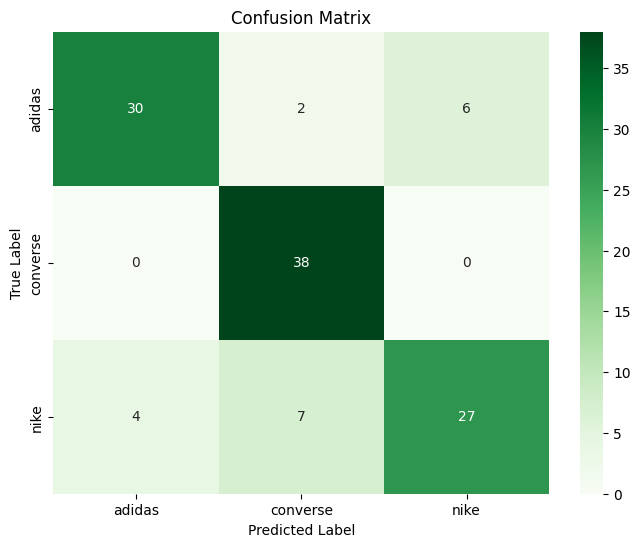

In [718]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for the test set
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))

# Generate confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Observation**:
The confusion matrix shows high correct predictions along the diagonal, which indicates good classification performance across all three classes (Adidas, Nike, Converse).
There are only a few off-diagonal values, suggesting minimal misclassification. If any class has more confusion (e.g., Adidas often predicted as Nike), it may indicate visual similarity between those brands in the dataset.

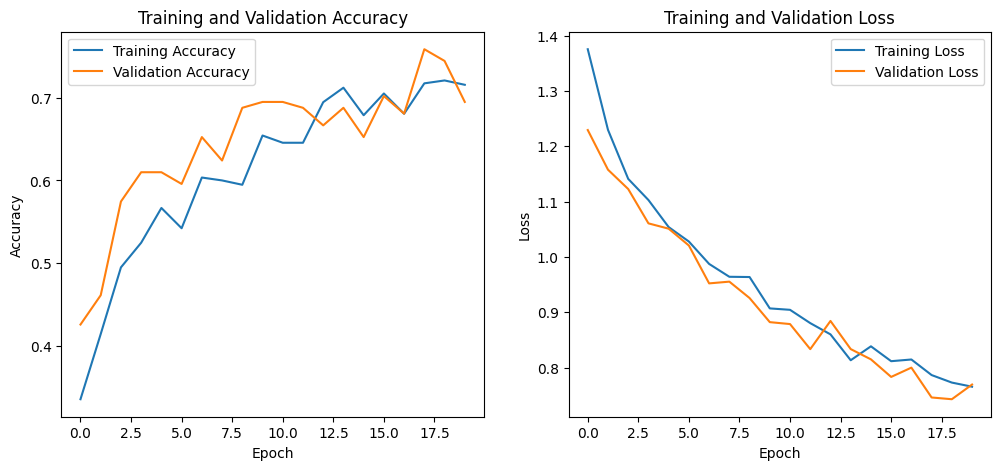

In [719]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Observation(Accuracy)**:
The training accuracy shows a steady increase over epochs, indicating that the model is learning effectively from the data. The validation accuracy follows a similar trend, suggesting that the model generalizes well to unseen data.
There is no major gap between training and validation accuracy, which means the model is not overfitting significantly.

**Observation (Loss)**:
The training loss decreases consistently, which is expected during proper learning. The validation loss also decreases but with minor fluctuations, which is normal in real-world datasets.
The absence of sharp increases in validation loss confirms that the model maintains stable performance and avoids overfitting.